# Data cleaning and preprocessing

This project is dedicated to the application of machine learning algorithms and tools to analysis of anthropological and sociological datasets. We would experiment with both supervised and unsupervised learning algorithms, such as clustering, decision trees, association rules, and artificial neural networks and many others. The goal is to extract meaningful patterns from such datasets as World Value Survey.

Before we apply any algorithms to the WVS data, we need to make sure that the data has high quality. We need to detect and correct corrupt, invalid, or inaccurate records from the data set and changing the range of data value for easiler processing later.

# 1. Normalization

In [1]:
file_name = "../data_set/cultural_data/clean_data/clean_data.csv"
WVS_questions = "../data_set/cultural_data/WVS_topics_ questions.csv"
country_name = "../data_set/cultural_data/clean_data/country_code.csv"

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv(file_name,header=None)
questions = pd.read_csv(WVS_questions,header=None)
country = pd.read_csv(country_name,header=None)

In [3]:
questions.columns = ["title","min","max","type","norm_type"]
data.columns = questions["title"]
country.columns = ["name"]
print(data)
print(questions)

title   V2  V4  V5  V6  V7  V8  V9  V10  V11  V12  ...   V247  V248  V249  \
0       12   1   1   1  -2   1   1    2    1    1  ...  12001   7.0    24   
1       12   1   2   3   4   2   2    2    2    2  ...  12001   7.0    25   
2       12   1   3   2   4   2   1    2    2    2  ...  12002   5.0    18   
3       12   1   1   3   4   3   1    2    1    2  ...  12002   6.0    14   
4       12   1   1   1   2   1   1    1    3    2  ...  12002   3.0     8   
...    ...  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...    ...   ...   ...   
90345  716   1   3   2   4   1   1    3    3    2  ...    405   4.0    16   
90346  716   1   1   1   3   1   1    3    1    2  ...    405   5.0    18   
90347  716   1   2   1   3   1   1    3    3    2  ...    405   2.0     9   
90348  716   1   2   2   3   1   1    2    2    2  ...    405   5.0    32   
90349  716   1   2   2   2   2   1    2    2    2  ...    405   4.0    15   

title  V250  V251  V252  V253   V254  V255  V258  
0         1     2     2 

In [4]:
# Processing country names
new = country['name'].str.split("'", n = 1, expand = True)
new[1] = new[1].str.replace("'","")
new[0] = new[0].astype(int)
country['index'], country['name'] = new[0],new[1]
print(country)

                    name  index
0       Missing; Unknown     -5
1    Not asked in survey     -4
2         Not applicable     -3
3              No answer     -2
4              Dont know     -1
..                   ...    ...
197               Bosnia    914
198               Kosovo    915
199     Flanders-Belgium    916
200        Israel (Jews)    917
201       Israel (Arabs)    918

[202 rows x 2 columns]


In [5]:
country_data = data.groupby(["V2"]).count().sort_values(["V4"],ascending=False)

country_df = pd.DataFrame(columns=["name","index","respondents"])
country_df["index"] = country_data.index
country_df["respondents"] = np.array(country_data['V4'])

country_df["name"] = [country[country['index'] == x]['name'].iloc[0] for x in country_df["index"]]

print(country_df)
print(country_df["respondents"].sum(),len(data))

                   name  index  respondents
0                 India    356         5659
1          South Africa    710         3531
2                Russia    643         2500
3                 Japan    392         2443
4                 China    156         2300
5         United States    840         2232
6                 Libya    434         2131
7               Germany    276         2046
8                Mexico    484         2000
9             Singapore    702         1972
10          Netherlands    528         1902
11              Nigeria    566         1759
12               Turkey    792         1605
13                Ghana    288         1552
14              Belarus    112         1535
15              Estonia    233         1533
16               Rwanda    646         1527
17                Egypt    818         1523
18             Colombia    170         1512
19              Romania    642         1503
20              Ukraine    804         1500
21           Kazakhstan    398  

In [6]:
data = data.drop(columns=["V144","V254","V247"])
data = data.drop(columns=["V2","V241","V251","V252","V258","V44_ES"])

In [7]:
# Deal with not applicable value
from sklearn.impute import SimpleImputer

# Combine columns of invalid value
ls = [[],[]]
ls[0] = ['V125_'+str(i) for i in range(16)]
ls[1] = ['V215_'+str(i) for i in range(1,19)]
ls[1].remove('V215_9')
name = ['V125','V215']

for i in range(len(ls)):
    columns = ls[i]
    frames = []
    result = pd.DataFrame(index=data.index)

    for column in columns:
        cur_data = data[data[column] != -4][column]
        frames.append(cur_data)

    result = pd.concat(frames)
    result_clean = result.reset_index().drop_duplicates(subset='index',keep='first').set_index('index')
        
    index = data.columns.get_loc(columns[0])
    data = data.drop(columns=columns)
    n = name[i]
    data.insert(index,n,result_clean)

    question = questions[questions['title'] == ls[i][0]].iloc[0]
    row = [n,question['min'],question['max'],question['type'],3]
    a_series = pd.Series(row, index = questions.columns)
    questions = questions.append(a_series, ignore_index=True)

print(data['V125'])


0        4.0
1        4.0
2        3.0
3        3.0
4        3.0
        ... 
90345    3.0
90346    3.0
90347    2.0
90348    4.0
90349    3.0
Name: V125, Length: 90350, dtype: float64


In [8]:
# Impute negative value elsewhere
data[data<0] = np.nan

imp = SimpleImputer(missing_values=np.nan,strategy="most_frequent")
df = pd.DataFrame(imp.fit_transform(data))
df.columns=data.columns
df.index=data.index
# print(df.columns)
print(questions[questions["title"]=='V125'])

# Normalize the data
for column in df.columns:
    minimum = int(df[column].min())
    maximum = int(df[column].max())
    print(questions[questions["title"]==column].norm_type)
    norm_type = questions[questions["title"]==column].norm_type.iloc[0]
    
    if norm_type == 2:
#         print(df)
        for i in range(minimum,maximum+1):
            index = df.columns.get_loc(column) + i
            name = column+"_"+str(i)
            col = [0]*len(df[column])
            for j in range(len(df[column])):
                col[j] = 1 if df[column][j] == i else 0
            df.insert(index,name,col)
        df = df.drop(columns=[column])

    elif norm_type == 1:
        df[column] = (df[column]-minimum)/(maximum-minimum)
        
    elif norm_type == 3:
        df[column] = 1-(df[column]-minimum)/(maximum-minimum)
        
print(df["V57_1"])

    title  min  max     type  norm_type
312  V125    1    4  Society          3
1    1
Name: norm_type, dtype: int64
2    1
Name: norm_type, dtype: int64
3    1
Name: norm_type, dtype: int64
4    1
Name: norm_type, dtype: int64
5    1
Name: norm_type, dtype: int64
6    1
Name: norm_type, dtype: int64
7    3
Name: norm_type, dtype: int64
8    3
Name: norm_type, dtype: int64
9    3
Name: norm_type, dtype: int64
10    3
Name: norm_type, dtype: int64
11    3
Name: norm_type, dtype: int64
12    3
Name: norm_type, dtype: int64
13    3
Name: norm_type, dtype: int64
14    3
Name: norm_type, dtype: int64
15    3
Name: norm_type, dtype: int64
16    3
Name: norm_type, dtype: int64
17    3
Name: norm_type, dtype: int64
18    3
Name: norm_type, dtype: int64
19    3
Name: norm_type, dtype: int64
20    1
Name: norm_type, dtype: int64
21    3
Name: norm_type, dtype: int64
22    1
Name: norm_type, dtype: int64
23    1
Name: norm_type, dtype: int64
24    1
Name: norm_type, dtype: int64
25    1
Name: nor

61    2
Name: norm_type, dtype: int64
title   V4        V5        V6        V7        V8        V9       V10  \
0      0.0  0.000000  0.000000  0.666667  0.000000  0.000000  0.666667   
1      0.0  0.333333  0.666667  1.000000  0.333333  0.333333  0.666667   
2      0.0  0.666667  0.333333  1.000000  0.333333  0.000000  0.666667   
3      0.0  0.000000  0.666667  1.000000  0.666667  0.000000  0.666667   
4      0.0  0.000000  0.000000  0.333333  0.000000  0.000000  1.000000   
...    ...       ...       ...       ...       ...       ...       ...   
90345  0.0  0.666667  0.333333  1.000000  0.000000  0.000000  0.333333   
90346  0.0  0.000000  0.000000  0.666667  0.000000  0.000000  0.333333   
90347  0.0  0.333333  0.000000  0.666667  0.000000  0.000000  0.333333   
90348  0.0  0.333333  0.333333  0.666667  0.000000  0.000000  0.666667   
90349  0.0  0.333333  0.333333  0.333333  0.333333  0.000000  0.666667   

title       V11  V12  V13  ...  V242  V243  V244  V245  V246  V248  V249 

65    3
Name: norm_type, dtype: int64
66    3
Name: norm_type, dtype: int64
67    3
Name: norm_type, dtype: int64
68    3
Name: norm_type, dtype: int64
69    3
Name: norm_type, dtype: int64
70    3
Name: norm_type, dtype: int64
71    3
Name: norm_type, dtype: int64
72    3
Name: norm_type, dtype: int64
73    3
Name: norm_type, dtype: int64
74    3
Name: norm_type, dtype: int64
75    3
Name: norm_type, dtype: int64
76    3
Name: norm_type, dtype: int64
77    3
Name: norm_type, dtype: int64
78    3
Name: norm_type, dtype: int64
79    3
Name: norm_type, dtype: int64
80    2
Name: norm_type, dtype: int64
title   V4        V5        V6        V7        V8        V9       V10  \
0      0.0  0.000000  0.000000  0.666667  0.000000  0.000000  0.666667   
1      0.0  0.333333  0.666667  1.000000  0.333333  0.333333  0.666667   
2      0.0  0.666667  0.333333  1.000000  0.333333  0.000000  0.666667   
3      0.0  0.000000  0.666667  1.000000  0.666667  0.000000  0.666667   
4      0.0  0.000000  

233    1
Name: norm_type, dtype: int64
234    1
Name: norm_type, dtype: int64
235    1
Name: norm_type, dtype: int64
236    1
Name: norm_type, dtype: int64
237    1
Name: norm_type, dtype: int64
238    1
Name: norm_type, dtype: int64
239    1
Name: norm_type, dtype: int64
240    3
Name: norm_type, dtype: int64
241    3
Name: norm_type, dtype: int64
242    3
Name: norm_type, dtype: int64
243    3
Name: norm_type, dtype: int64
313    3
Name: norm_type, dtype: int64
261    3
Name: norm_type, dtype: int64
262    3
Name: norm_type, dtype: int64
263    3
Name: norm_type, dtype: int64
264    3
Name: norm_type, dtype: int64
265    3
Name: norm_type, dtype: int64
266    3
Name: norm_type, dtype: int64
267    3
Name: norm_type, dtype: int64
268    3
Name: norm_type, dtype: int64
269    3
Name: norm_type, dtype: int64
270    1
Name: norm_type, dtype: int64
271    3
Name: norm_type, dtype: int64
272    3
Name: norm_type, dtype: int64
273    3
Name: norm_type, dtype: int64
274    3
Name: norm_type,

After cleaning up data and normilizing data, we can begin to use kmeans model implemented in sklearn to cluster data.

We compute SSE for each cluster size, plot it on the graph and try to find an elbow point that indicated the best k value.

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


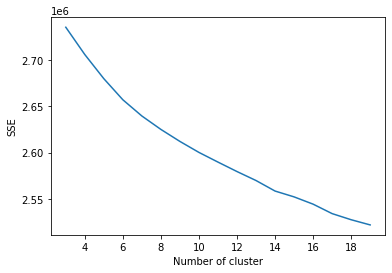

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

sse = {}
for i in range(3,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df)
    sse[i] = kmeans.inertia_ 
    print(i)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()
